In [1]:
import numpy as np
import pandas as pd

In [4]:
from sklearn.metrics import make_scorer, accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool

In [2]:
import pandas as pd
df = pd.read_excel('bmc_cases.xlsb', engine='pyxlsb')

In [3]:
len(df) - df.isna().sum()

Date                                           116227
S No                                            68923
Ward                                           116227
Test ID (ICMR)                                 116214
Patient name                                        0
Age                                            116227
Gender                                         116227
Mobile Number                                       0
Present Address                                     0
Transferred from Ward                           11704
HealthPost Allocation                           94160
Traceable?                                     114419
Out of Mumbai (Yes / No)                        89095
Assign to other ward                             7701
Person / Official from other ward                8330
Duplicate Entry\n(Yes / No)                     81883
Previous Test ID (only if Duplicate is Yes)       368
Patient Type (Index / Contact)                  89044
Patient Status              

In [5]:
data = df[['Ward','Date','Age','Gender','Symptomatic?','Traceable?','Patient Location','Patient Status (Central)','Occupation','Patient Type (Index / Contact)']]

In [6]:
data['Symptomatic?'].value_counts()

Yes               45448
No                36118
YES                 150
NO                  133
no                   28
yes                  16
CCC2                  1
44031.74513           1
Home Isolation        1
No (ANC)              1
Name: Symptomatic?, dtype: int64

In [7]:
allowed_params = {'Symptomatic?':(['Yes','No'],'Unknown'),
                  'Traceable?':(['Yes','No'],'Unknown'),
                    'Patient Location':(['Building','Slum / Chawl'],'Unknown'),
                    'Occupation':(['At-home worker','Health worker','Other essential services','Municipal Worker','Police','RETIRED','House Wife'],'Others'),
                'Patient Type (Index / Contact)':(['Index','Contact'],'Unknown'),
                  'Gender':(['M','F'],'Others')
                 }
                    

In [8]:
def get_val(column_val,allowed):
    if column_val in allowed[0]:
        return column_val
    return allowed[1]

In [9]:
for feature in allowed_params:
    data[feature] = data.apply(lambda row : get_val(row[feature],allowed_params[feature]),axis = 1) 

<ipython-input-9-84f81ea0ce27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = data.apply(lambda row : get_val(row[feature],allowed_params[feature]),axis = 1)


In [10]:
data

,Ward,Date,Age,Gender,Symptomatic?,Traceable?,Patient Location,Patient Status (Central),Occupation,Patient Type (Index / Contact)
0,A,43956,56,F,No,Yes,Slum / Chawl,Under reconciliation,Others,Contact
1,A,43959,38,F,Unknown,Yes,Unknown,Recovered,Others,Unknown
2,A,43960,31,F,Unknown,Unknown,Unknown,Recovered,Others,Unknown
3,A,43960,57,M,Unknown,Yes,Unknown,Recovered,Others,Unknown
4,A,43960,44,F,Unknown,Yes,Unknown,Recovered,Others,Unknown
...,...,...,...,...,...,...,...,...,...,...
116222,T,44032,53,M,Yes,Yes,Building,Dead,Other essential services,Index
116223,T,44034,85,M,Yes,Yes,Building,Dead,At-home worker,Index
116224,T,44037,58,M,Yes,Yes,Building,Dead,Others,Index
116225,T,44040,70,M,Yes,Yes,Building,NaN,At-home worker,Index


In [11]:
df = data[(data['Patient Status (Central)'] == 'Recovered') | (data['Patient Status (Central)'] == 'Dead')]

In [12]:
y = df['Patient Status (Central)']
X = df.drop(['Patient Status (Central)'],axis = 1)

In [13]:
print(X['Symptomatic?'].value_counts())

Yes        35645
Unknown    32031
No         29752
Name: Symptomatic?, dtype: int64


In [14]:
print(X.dtypes)
categorical_features_indices = np.where((X.dtypes == object))[0]
categorical_features_indices

Ward                              object
Date                               int64
Age                                int64
Gender                            object
Symptomatic?                      object
Traceable?                        object
Patient Location                  object
Occupation                        object
Patient Type (Index / Contact)    object
dtype: object


array([0, 3, 4, 5, 6, 7, 8])

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [16]:
from collections import Counter
y_count = Counter(y)
print(y_count)
W = {}
W[0]= len(y)/(2*y_count[0])
W[1] = len(y)/(2*y_count[1])
print(W)

Counter({1: 91487, 0: 5941})
{0: 8.19962969197105, 1: 0.532469093969635}


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [25]:
X_train_pool = Pool(X_train,label = y_train,cat_features=categorical_features_indices)
clf = CatBoostClassifier()
params = {'iterations': [500],
          'depth': [6, 8 , 10],
          'cat_features':[categorical_features_indices],
          'loss_function': ['Logloss'],
          'l2_leaf_reg': np.linspace(1, 6, 4),
          'leaf_estimation_iterations': [10],
          'verbose':[500],
          'class_weights' : [W]
         }


In [26]:
scorer = make_scorer(roc_auc_score)
clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring=scorer, cv=5)

In [27]:
clf_grid.fit(
    X_train, y_train,
);

0:	learn: 0.6827249	total: 37.8ms	remaining: 18.9s
499:	learn: 0.4655853	total: 19.5s	remaining: 0us
0:	learn: 0.6831539	total: 49.5ms	remaining: 24.7s
499:	learn: 0.4660455	total: 18.6s	remaining: 0us
0:	learn: 0.6827759	total: 36.5ms	remaining: 18.2s
499:	learn: 0.4641726	total: 18.8s	remaining: 0us
0:	learn: 0.6850100	total: 30ms	remaining: 15s
499:	learn: 0.4673684	total: 18.8s	remaining: 0us
0:	learn: 0.6845878	total: 30.3ms	remaining: 15.1s
499:	learn: 0.4637981	total: 19.6s	remaining: 0us
0:	learn: 0.6827630	total: 49.4ms	remaining: 24.7s
499:	learn: 0.4681721	total: 17.5s	remaining: 0us
0:	learn: 0.6831556	total: 42ms	remaining: 21s
499:	learn: 0.4711487	total: 16.9s	remaining: 0us
0:	learn: 0.6827810	total: 41.9ms	remaining: 20.9s
499:	learn: 0.4672339	total: 17s	remaining: 0us
0:	learn: 0.6850100	total: 28.7ms	remaining: 14.3s
499:	learn: 0.4706298	total: 17s	remaining: 0us
0:	learn: 0.6846022	total: 30.6ms	remaining: 15.3s
499:	learn: 0.4677736	total: 17.2s	remaining: 0us
0:

In [106]:
best_param = clf_grid.best_params_
best_param

{'cat_features': array([0, 3, 4, 5, 6, 7, 8]),
 'class_weights': {0: 8.19962969197105, 1: 0.532469093969635},
 'depth': 6,
 'iterations': 500,
 'l2_leaf_reg': 6.0,
 'leaf_estimation_iterations': 10,
 'loss_function': 'Logloss',
 'random_seed': 42,
 'verbose': 500}

In [107]:
model = CatBoostClassifier(iterations=1000,
                           loss_function=best_param['loss_function'],
                           depth=best_param['depth'],
                           l2_leaf_reg=best_param['l2_leaf_reg'],
                           eval_metric='Accuracy',
                           leaf_estimation_iterations=10,
                           use_best_model=True,
                           logging_level='Silent'
                          );

In [108]:
model.fit(X_train_pool, eval_set=(X_val,y_val))

In [109]:
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)

In [110]:
W

{0: 8.19962969197105, 1: 0.532469093969635}

In [111]:
from sklearn.metrics import classification_report,confusion_matrix,plot_roc_curve
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.87      0.03      0.05      1239
           1       0.94      1.00      0.97     18247

    accuracy                           0.94     19486
   macro avg       0.90      0.51      0.51     19486
weighted avg       0.93      0.94      0.91     19486



In [112]:
confusion_matrix(y_test,predictions)

array([[   33,  1206],
       [    5, 18242]])

In [113]:
df = pd.DataFrame({"Features":X.columns,"Importance":model.get_feature_importance(verbose=True)})
df.sort_values(by = 'Importance',ascending = False)

,Features,Importance
2,Age,50.293245
4,Symptomatic?,26.589881
1,Date,5.649801
0,Ward,5.448067
6,Patient Location,5.333976
8,Patient Type (Index / Contact),3.071668
3,Gender,1.387593
7,Occupation,1.365069
5,Traceable?,0.860701


In [114]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

In [115]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})

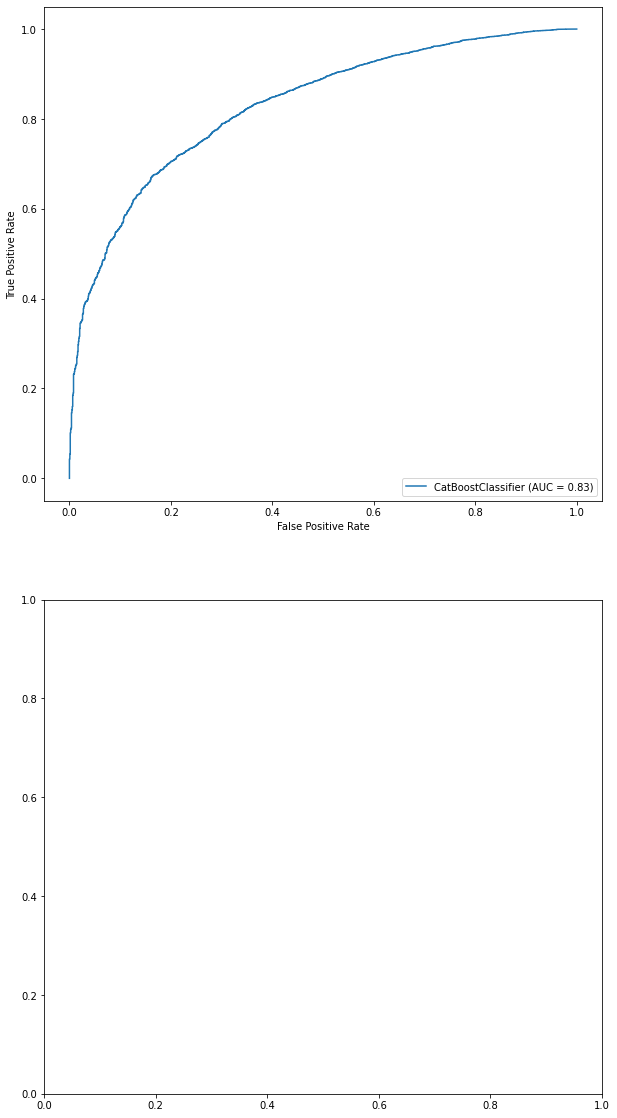

In [116]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,1,figsize=[10,20])
plot_roc_curve(model,X_test,y_test,ax =ax.flat[0])
plot_precision_recall_curve(model,X_test,y_test,ax =ax.flat[1])

In [ ]:
model.plot_tree(0)

In [ ]:
tree_dict = {}
tree_data = X_test[['Age','Symptomatic?','label']]
age_bins = [0,29.5,46.5,62.5,150]
bins = [(age_bins[i],age_bins[i+1]) for i in range(len(age_bins)-1)]
sym_classes = list(tree_data['Symptomatic?'].value_counts().keys())
test_g = tree_data.groupby(pd.cut(tree_data['Age'],bins =age_bins ))
print(bins)
print(sym_classes)
for age_bin,df_group in test_g:
    tree_dict[(age_bin.left,age_bin.right)] = {}
    test_g2 = df_group.groupby(df_group["Symptomatic?"])
    for sym_bin,df_group2 in test_g2:
        tree_dict[(age_bin.left,age_bin.right)][sym_bin] = df_group2['label'].value_counts()
for b in bins:
    for s in sym_classes:
        print(b,s)
        print(tree_dict[b][s])
        print('-'*10)